In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms

# Modify size of images, convert them to tensors and normalize them, hence use transform composition to do so
transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_set = CIFAR10(root='data/', train=False, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
testloader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = torch.device('cuda:0')

In [ ]:
import torchvision.models as models
import torch.nn as nn

# ALEXNET originally outputs up to 1000 classes, hence modify its output layer in-place to output only 10 classes as predictions

alexnet_model = models.alexnet(pretrained=True)
alexnet_model.classifier[6] = nn.Linear(4096, 10)
alexnet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Perform GPU mapping to improve processing time 
alexnet_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
predictions = []
trues = []

# Each iteration of trainloader grabs a set of image-matrices equal to the batch-size
# Batch-size is 8 therefore load 8 image matrices per iteration in tensor 
# Ensure no gradient computed, in testing only no changes being made
with torch.no_grad():
  for i, data in enumerate(testloader):
    images, labels = data[0].to(device), data[1].to(device)
    # Retrieve from CPU memory as CUDA core storage is unique
    trues.append(labels.cpu().numpy())
    outputs = alexnet_model(images)

    # Retrieve max elem along axis = 1, hence across the columns of the output tensor of labels equivalent to batch-size
    # Hence output 1D vectors of size 8 
    _, predicted = torch.max(outputs, 1)
    predictions.append(predicted.cpu().numpy())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from sklearn.metrics import confusion_matrix

predictions = np.array(predictions)
trues = np.array(trues)

cfm = confusion_matrix(trues.flatten(), predictions.flatten(), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], normalize='true')
cfm_denorm = confusion_matrix(trues.flatten(), predictions.flatten(), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cfm_denorm

array([[ 11, 132, 436,   3,  74,   1,   9, 325,   7,   2],
       [ 17, 108, 558,  23,  33,   0, 104, 151,   2,   4],
       [  9, 170, 374,   5,  12,   1,   4, 371,  53,   1],
       [ 17,  92, 424,  18,  14,   0,   4, 422,   9,   0],
       [ 34, 321, 403,   3,   3,   0,   1, 183,  52,   0],
       [ 21, 156, 312,  16,   4,   0,   3, 478,   5,   5],
       [ 34,  98, 668,   3,  29,   0,   0, 128,  39,   1],
       [ 25, 312, 246,   2,   5,   0,   8, 394,   7,   1],
       [ 18, 170, 399,   1,  68,   0,  12, 327,   3,   2],
       [ 40, 140, 584,   8,  28,   0,  59, 141,   0,   0]])

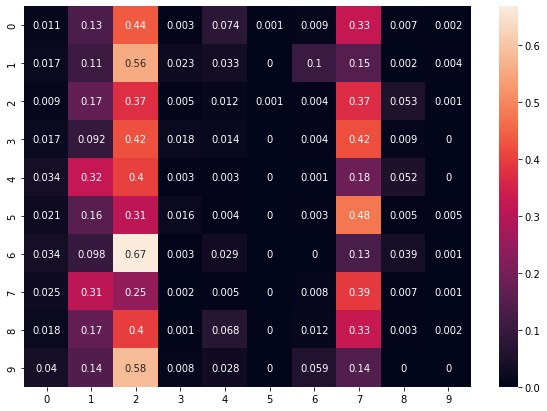

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cfm, index = [i for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]],
                  columns = [i for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)